In [2]:
import os
import math
import time
from pathlib import Path
from tqdm.auto import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt



In [3]:
# SPEED CONFIG
torch.backends.cudnn.benchmark = True       #Fast CNN kernels
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True

#PATH CONFIG
DATA_DIR = r"C:\Users\AL IMRAN\Desktop\CSE498R\Local\Dataset_Final_V2_Split"
TRAIN_DIR = os.path.join(DATA_DIR, "train")
VAL_DIR   = os.path.join(DATA_DIR, "val")


In [4]:
#TRAIN CONFIG
IMG_SIZE = 224
BATCH_SIZE = 128
NUM_WORKERS = 2          
PIN_MEMORY = True
PERSISTENT = True

NUM_CLASSES = 52
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
SEED = 42
EPOCHS = 100
MODEL_OUT =  r"C:\Users\AL IMRAN\Desktop\CSE498R\Local\best_model.pth"


torch.manual_seed(SEED)


In [5]:
# FAST TRANSFORMS 
train_tf = transforms.Compose([
    transforms.RandomResizedCrop(IMG_SIZE),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
])

val_tf = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])


In [6]:
# LOAD DATASETS
train_ds = ImageFolder(TRAIN_DIR, transform=train_tf)
val_ds   = ImageFolder(VAL_DIR, transform=val_tf)

train_loader = DataLoader(
    train_ds,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=PIN_MEMORY,
    persistent_workers=PERSISTENT
)

val_loader = DataLoader(
    val_ds,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=PIN_MEMORY,
    persistent_workers=PERSISTENT
)

print("DataLoader ready — GPU optimized")

DataLoader ready — GPU optimized


In [7]:
#  model definition (custom CNN)

#Custom CNN tuned to ~1.24M parameters
#conv channels: [48, 72, 120, 192, 256]
# adaptive avg pool -> FC(1536) -> FC(num_classes)
    


class ConvBlock(nn.Module):
    def __init__(self, in_c, out_c, pool=True):
        super().__init__()
        self.conv = nn.Conv2d(in_c, out_c, kernel_size=3, padding=1, bias=False)
        self.bn   = nn.BatchNorm2d(out_c)
        self.act  = nn.ReLU(inplace=True)
        self.pool = pool
        if pool:
            self.pool_layer = nn.MaxPool2d(2,2)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.act(x)
        if self.pool:
            x = self.pool_layer(x)
        return x

class LeafCNN(nn.Module):

    def __init__(self, num_classes=52):
        super().__init__()
        ch = [48, 72, 120, 192, 256]
        self.layer1 = ConvBlock(3,   ch[0], pool=True)   # out: 48 x 112 x 112
        self.layer2 = ConvBlock(ch[0], ch[1], pool=True) # 72 x 56 x 56
        self.layer3 = ConvBlock(ch[1], ch[2], pool=True) # 120 x 28 x 28
        self.layer4 = ConvBlock(ch[2], ch[3], pool=True) # 192 x 14 x 14
        self.layer5 = ConvBlock(ch[3], ch[4], pool=True) # 256 x 7 x 7

        self.global_pool = nn.AdaptiveAvgPool2d((1,1))  # -> 256 feature vector
        self.fc1 = nn.Linear(ch[-1], 1536)  # chosen to push param count into desired range
        self.dropout = nn.Dropout(0.463302980)
        self.fc2 = nn.Linear(1536, num_classes)

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        x = self.global_pool(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x, inplace=True)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# instantiate and move to device
model = LeafCNN(num_classes=NUM_CLASSES).to(DEVICE)

# helper: parameter count
def count_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print("Model params:", count_params(model))   # should be ~1.2M


Model params: 1235940


In [8]:
# training utilities (loss, optimizer, scheduler)
import copy

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min',
                                                       factor=0.5, patience=3, verbose=True)

def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    pbar = tqdm(loader, leave=False)
    for images, labels in pbar:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += images.size(0)
        pbar.set_description(f"loss={loss.item():.4f}")

    epoch_loss = running_loss / total
    epoch_acc  = correct / total
    return epoch_loss, epoch_acc

def validate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * images.size(0)
            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += images.size(0)
    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc


C:\Users\alimran\anaconda3\envs\torch_env\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [9]:
# TRAINING LOOP 

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0009493568750)  # hyperparameter tuning 
scaler = torch.cuda.amp.GradScaler()

best_val_loss = float('inf')
history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}

for epoch in range(1, EPOCHS + 1):
    print(f"\n===== Epoch {epoch}/{EPOCHS} =====")

    #  TRAIN
    model.train()
    train_loss, train_correct, total = 0.0, 0, 0

    for images, labels in tqdm(train_loader, desc="Training", leave=False):
        images = images.to(DEVICE, non_blocking=True)
        labels = labels.to(DEVICE, non_blocking=True)

        optimizer.zero_grad()

        with torch.cuda.amp.autocast():
            outputs = model(images)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        train_loss += loss.item() * images.size(0)
        train_correct += (outputs.argmax(1) == labels).sum().item()
        total += labels.size(0)

    train_loss /= total
    train_acc = train_correct / total

    #  VALIDATE 
    model.eval()
    val_loss, val_correct, total_val = 0.0, 0, 0

    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc="Validation", leave=False):
            images = images.to(DEVICE, non_blocking=True)
            labels = labels.to(DEVICE, non_blocking=True)

            with torch.cuda.amp.autocast():
                outputs = model(images)
                loss = criterion(outputs, labels)

            val_loss += loss.item() * images.size(0)
            val_correct += (outputs.argmax(1) == labels).sum().item()
            total_val += labels.size(0)

    val_loss /= total_val
    val_acc = val_correct / total_val

    #   SAVE  
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), MODEL_OUT)
        print(" Best model updated & saved!")

    #   HISTORY 
    history["train_loss"].append(train_loss)
    history["train_acc"].append(train_acc)
    history["val_loss"].append(val_loss)
    history["val_acc"].append(val_acc)

    #  LOG OUTPUT 
    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f"Val   Loss: {val_loss:.4f} | Val   Acc: {val_acc:.4f}")

print("\n Training Completed!")
print("Best model saved to:", MODEL_OUT)


C:\Users\AL IMRAN\AppData\Local\Temp\ipykernel_7272\3414068775.py:5: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()



===== Epoch 1/100 =====


C:\Users\AL IMRAN\AppData\Local\Temp\ipykernel_7272\3414068775.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
C:\Users\AL IMRAN\AppData\Local\Temp\ipykernel_7272\3414068775.py:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
                                                                                                                       

 Best model updated & saved!
Train Loss: 1.2310 | Train Acc: 0.6285
Val   Loss: 0.5824 | Val   Acc: 0.8126

===== Epoch 2/100 =====


Train Loss: 0.5990 | Train Acc: 0.8077
Val   Loss: 1.4609 | Val   Acc: 0.6373

===== Epoch 3/100 =====


 Best model updated & saved!
Train Loss: 0.4672 | Train Acc: 0.8489
Val   Loss: 0.2936 | Val   Acc: 0.9010

===== Epoch 4/100 =====


Train Loss: 0.3934 | Train Acc: 0.8727
Val   Loss: 0.4272 | Val   Acc: 0.8594

===== Epoch 5/100 =====


 Best model updated & saved!
Train Loss: 0.3394 | Train Acc: 0.8891
Val   Loss: 0.1948 | Val   Acc: 0.9345

===== Epoch 6/100 =====


Train Loss: 0.3098 | Train Acc: 0.8991
Val   Loss: 0.1974 | Val   Acc: 0.9315

===== Epoch 7/100 =====


Train Loss: 0.2845 | Train Acc: 0.9078
Val   Loss: 0.1962 | Val   Acc: 0.9338

===== Epoch 8/100 =====


 Best model updated & saved!
Train Loss: 0.2592 | Train Acc: 0.9151
Val   Loss: 0.1839 | Val   Acc: 0.9391

===== Epoch 9/100 =====


Train Loss: 0.2462 | Train Acc: 0.9198
Val   Loss: 0.2357 | Val   Acc: 0.9249

===== Epoch 10/100 =====


Train Loss: 0.2277 | Train Acc: 0.9264
Val   Loss: 0.1906 | Val   Acc: 0.9336

===== Epoch 11/100 =====


 Best model updated & saved!
Train Loss: 0.2144 | Train Acc: 0.9302
Val   Loss: 0.1233 | Val   Acc: 0.9580

===== Epoch 12/100 =====


 Best model updated & saved!
Train Loss: 0.2048 | Train Acc: 0.9340
Val   Loss: 0.0932 | Val   Acc: 0.9665

===== Epoch 13/100 =====


Train Loss: 0.1900 | Train Acc: 0.9380
Val   Loss: 0.1151 | Val   Acc: 0.9605

===== Epoch 14/100 =====


 Best model updated & saved!
Train Loss: 0.1883 | Train Acc: 0.9385
Val   Loss: 0.0801 | Val   Acc: 0.9723

===== Epoch 15/100 =====


Train Loss: 0.1720 | Train Acc: 0.9437
Val   Loss: 0.2374 | Val   Acc: 0.9310

===== Epoch 16/100 =====


Train Loss: 0.1684 | Train Acc: 0.9446
Val   Loss: 0.2009 | Val   Acc: 0.9376

===== Epoch 17/100 =====


 Best model updated & saved!
Train Loss: 0.1614 | Train Acc: 0.9474
Val   Loss: 0.0644 | Val   Acc: 0.9772

===== Epoch 18/100 =====


Train Loss: 0.1555 | Train Acc: 0.9490
Val   Loss: 0.0896 | Val   Acc: 0.9694

===== Epoch 19/100 =====


 Best model updated & saved!
Train Loss: 0.1504 | Train Acc: 0.9508
Val   Loss: 0.0524 | Val   Acc: 0.9826

===== Epoch 20/100 =====


Train Loss: 0.1457 | Train Acc: 0.9518
Val   Loss: 0.2289 | Val   Acc: 0.9335

===== Epoch 21/100 =====


Train Loss: 0.1394 | Train Acc: 0.9550
Val   Loss: 0.0681 | Val   Acc: 0.9764

===== Epoch 22/100 =====


Train Loss: 0.1357 | Train Acc: 0.9555
Val   Loss: 0.2821 | Val   Acc: 0.9167

===== Epoch 23/100 =====


 Best model updated & saved!
Train Loss: 0.1323 | Train Acc: 0.9570
Val   Loss: 0.0494 | Val   Acc: 0.9822

===== Epoch 24/100 =====


 Best model updated & saved!
Train Loss: 0.1289 | Train Acc: 0.9576
Val   Loss: 0.0465 | Val   Acc: 0.9833

===== Epoch 25/100 =====


Train Loss: 0.1235 | Train Acc: 0.9586
Val   Loss: 0.0599 | Val   Acc: 0.9795

===== Epoch 26/100 =====


Train Loss: 0.1231 | Train Acc: 0.9598
Val   Loss: 0.0649 | Val   Acc: 0.9762

===== Epoch 27/100 =====


Train Loss: 0.1146 | Train Acc: 0.9621
Val   Loss: 0.0771 | Val   Acc: 0.9743

===== Epoch 28/100 =====


 Best model updated & saved!
Train Loss: 0.1177 | Train Acc: 0.9618
Val   Loss: 0.0410 | Val   Acc: 0.9852

===== Epoch 29/100 =====


Train Loss: 0.1134 | Train Acc: 0.9631
Val   Loss: 0.0626 | Val   Acc: 0.9789

===== Epoch 30/100 =====


Train Loss: 0.1100 | Train Acc: 0.9637
Val   Loss: 0.0654 | Val   Acc: 0.9774

===== Epoch 31/100 =====


 Best model updated & saved!
Train Loss: 0.1089 | Train Acc: 0.9641
Val   Loss: 0.0392 | Val   Acc: 0.9858

===== Epoch 32/100 =====


Train Loss: 0.1085 | Train Acc: 0.9645
Val   Loss: 0.0415 | Val   Acc: 0.9850

===== Epoch 33/100 =====


Train Loss: 0.1054 | Train Acc: 0.9653
Val   Loss: 0.0695 | Val   Acc: 0.9776

===== Epoch 34/100 =====


Train Loss: 0.1007 | Train Acc: 0.9665
Val   Loss: 0.0408 | Val   Acc: 0.9866

===== Epoch 35/100 =====


Train Loss: 0.0978 | Train Acc: 0.9689
Val   Loss: 0.0829 | Val   Acc: 0.9719

===== Epoch 36/100 =====


 Best model updated & saved!
Train Loss: 0.0982 | Train Acc: 0.9676
Val   Loss: 0.0339 | Val   Acc: 0.9885

===== Epoch 37/100 =====


Train Loss: 0.0979 | Train Acc: 0.9682
Val   Loss: 0.0425 | Val   Acc: 0.9846

===== Epoch 38/100 =====


 Best model updated & saved!
Train Loss: 0.0940 | Train Acc: 0.9690
Val   Loss: 0.0266 | Val   Acc: 0.9910

===== Epoch 39/100 =====


Train Loss: 0.0925 | Train Acc: 0.9693
Val   Loss: 0.0401 | Val   Acc: 0.9859

===== Epoch 40/100 =====


Train Loss: 0.0956 | Train Acc: 0.9685
Val   Loss: 0.0629 | Val   Acc: 0.9778

===== Epoch 41/100 =====


 Best model updated & saved!
Train Loss: 0.0872 | Train Acc: 0.9717
Val   Loss: 0.0224 | Val   Acc: 0.9917

===== Epoch 42/100 =====


Train Loss: 0.0899 | Train Acc: 0.9710
Val   Loss: 0.0887 | Val   Acc: 0.9741

===== Epoch 43/100 =====


Train Loss: 0.0877 | Train Acc: 0.9710
Val   Loss: 0.0427 | Val   Acc: 0.9854

===== Epoch 44/100 =====


Train Loss: 0.0852 | Train Acc: 0.9719
Val   Loss: 0.0303 | Val   Acc: 0.9899

===== Epoch 45/100 =====


Train Loss: 0.0862 | Train Acc: 0.9714
Val   Loss: 0.0279 | Val   Acc: 0.9909

===== Epoch 46/100 =====


Train Loss: 0.0827 | Train Acc: 0.9728
Val   Loss: 0.0507 | Val   Acc: 0.9826

===== Epoch 47/100 =====


Train Loss: 0.0808 | Train Acc: 0.9729
Val   Loss: 0.0234 | Val   Acc: 0.9922

===== Epoch 48/100 =====


Train Loss: 0.0805 | Train Acc: 0.9735
Val   Loss: 0.0420 | Val   Acc: 0.9870

===== Epoch 49/100 =====


Train Loss: 0.0813 | Train Acc: 0.9739
Val   Loss: 0.0839 | Val   Acc: 0.9748

===== Epoch 50/100 =====


Train Loss: 0.0821 | Train Acc: 0.9732
Val   Loss: 0.0450 | Val   Acc: 0.9845

===== Epoch 51/100 =====


Train Loss: 0.0800 | Train Acc: 0.9736
Val   Loss: 0.0645 | Val   Acc: 0.9791

===== Epoch 52/100 =====


Train Loss: 0.0782 | Train Acc: 0.9742
Val   Loss: 0.0301 | Val   Acc: 0.9890

===== Epoch 53/100 =====


Train Loss: 0.0765 | Train Acc: 0.9749
Val   Loss: 0.0377 | Val   Acc: 0.9877

===== Epoch 54/100 =====


Train Loss: 0.0753 | Train Acc: 0.9754
Val   Loss: 0.0282 | Val   Acc: 0.9910

===== Epoch 55/100 =====


Train Loss: 0.0784 | Train Acc: 0.9744
Val   Loss: 0.0270 | Val   Acc: 0.9915

===== Epoch 56/100 =====


Train Loss: 0.0768 | Train Acc: 0.9748
Val   Loss: 0.0268 | Val   Acc: 0.9899

===== Epoch 57/100 =====


Train Loss: 0.0752 | Train Acc: 0.9752
Val   Loss: 0.0323 | Val   Acc: 0.9881

===== Epoch 58/100 =====


Train Loss: 0.0730 | Train Acc: 0.9767
Val   Loss: 0.0275 | Val   Acc: 0.9902

===== Epoch 59/100 =====


Train Loss: 0.0706 | Train Acc: 0.9766
Val   Loss: 0.0264 | Val   Acc: 0.9920

===== Epoch 60/100 =====


Train Loss: 0.0716 | Train Acc: 0.9766
Val   Loss: 0.0429 | Val   Acc: 0.9868

===== Epoch 61/100 =====


Train Loss: 0.0742 | Train Acc: 0.9756
Val   Loss: 0.0264 | Val   Acc: 0.9911

===== Epoch 62/100 =====


Train Loss: 0.0717 | Train Acc: 0.9763
Val   Loss: 0.0552 | Val   Acc: 0.9819

===== Epoch 63/100 =====


 Best model updated & saved!
Train Loss: 0.0702 | Train Acc: 0.9766
Val   Loss: 0.0202 | Val   Acc: 0.9936

===== Epoch 64/100 =====


Train Loss: 0.0697 | Train Acc: 0.9769
Val   Loss: 0.0266 | Val   Acc: 0.9908

===== Epoch 65/100 =====


Train Loss: 0.0682 | Train Acc: 0.9780
Val   Loss: 0.0353 | Val   Acc: 0.9879

===== Epoch 66/100 =====


 Best model updated & saved!
Train Loss: 0.0668 | Train Acc: 0.9772
Val   Loss: 0.0180 | Val   Acc: 0.9938

===== Epoch 67/100 =====


Train Loss: 0.0676 | Train Acc: 0.9776
Val   Loss: 0.0682 | Val   Acc: 0.9780

===== Epoch 68/100 =====


 Best model updated & saved!
Train Loss: 0.0658 | Train Acc: 0.9782
Val   Loss: 0.0152 | Val   Acc: 0.9949

===== Epoch 69/100 =====


Train Loss: 0.0675 | Train Acc: 0.9783
Val   Loss: 0.0253 | Val   Acc: 0.9909

===== Epoch 70/100 =====


Train Loss: 0.0664 | Train Acc: 0.9777
Val   Loss: 0.0169 | Val   Acc: 0.9937

===== Epoch 71/100 =====


Train Loss: 0.0646 | Train Acc: 0.9784
Val   Loss: 0.0462 | Val   Acc: 0.9855

===== Epoch 72/100 =====


Train Loss: 0.0642 | Train Acc: 0.9785
Val   Loss: 0.0265 | Val   Acc: 0.9912

===== Epoch 73/100 =====


Train Loss: 0.0644 | Train Acc: 0.9787
Val   Loss: 0.0213 | Val   Acc: 0.9929

===== Epoch 74/100 =====


Train Loss: 0.0646 | Train Acc: 0.9787
Val   Loss: 0.0185 | Val   Acc: 0.9940

===== Epoch 75/100 =====


Train Loss: 0.0607 | Train Acc: 0.9802
Val   Loss: 0.0244 | Val   Acc: 0.9928

===== Epoch 76/100 =====


Train Loss: 0.0611 | Train Acc: 0.9796
Val   Loss: 0.0235 | Val   Acc: 0.9926

===== Epoch 77/100 =====


Train Loss: 0.0639 | Train Acc: 0.9793
Val   Loss: 0.0188 | Val   Acc: 0.9941

===== Epoch 78/100 =====


Train Loss: 0.0636 | Train Acc: 0.9788
Val   Loss: 0.0200 | Val   Acc: 0.9933

===== Epoch 79/100 =====


Train Loss: 0.0625 | Train Acc: 0.9796
Val   Loss: 0.0174 | Val   Acc: 0.9939

===== Epoch 80/100 =====


Train Loss: 0.0611 | Train Acc: 0.9799
Val   Loss: 0.0258 | Val   Acc: 0.9909

===== Epoch 81/100 =====


Train Loss: 0.0639 | Train Acc: 0.9794
Val   Loss: 0.0261 | Val   Acc: 0.9914

===== Epoch 82/100 =====


Train Loss: 0.0602 | Train Acc: 0.9799
Val   Loss: 0.0207 | Val   Acc: 0.9937

===== Epoch 83/100 =====


Train Loss: 0.0598 | Train Acc: 0.9802
Val   Loss: 0.0344 | Val   Acc: 0.9892

===== Epoch 84/100 =====


 Best model updated & saved!
Train Loss: 0.0603 | Train Acc: 0.9804
Val   Loss: 0.0148 | Val   Acc: 0.9945

===== Epoch 85/100 =====


Train Loss: 0.0595 | Train Acc: 0.9802
Val   Loss: 0.0150 | Val   Acc: 0.9951

===== Epoch 86/100 =====


Train Loss: 0.0599 | Train Acc: 0.9801
Val   Loss: 0.0199 | Val   Acc: 0.9936

===== Epoch 87/100 =====


Train Loss: 0.0587 | Train Acc: 0.9807
Val   Loss: 0.0495 | Val   Acc: 0.9845

===== Epoch 88/100 =====


Train Loss: 0.0560 | Train Acc: 0.9812
Val   Loss: 0.0397 | Val   Acc: 0.9877

===== Epoch 89/100 =====


Train Loss: 0.0577 | Train Acc: 0.9810
Val   Loss: 0.0253 | Val   Acc: 0.9911

===== Epoch 90/100 =====


Train Loss: 0.0569 | Train Acc: 0.9812
Val   Loss: 0.0153 | Val   Acc: 0.9950

===== Epoch 91/100 =====


Train Loss: 0.0609 | Train Acc: 0.9803
Val   Loss: 0.0226 | Val   Acc: 0.9944

===== Epoch 92/100 =====


Train Loss: 0.0584 | Train Acc: 0.9805
Val   Loss: 0.0226 | Val   Acc: 0.9930

===== Epoch 93/100 =====


Train Loss: 0.0584 | Train Acc: 0.9810
Val   Loss: 0.0217 | Val   Acc: 0.9933

===== Epoch 94/100 =====


Train Loss: 0.0576 | Train Acc: 0.9813
Val   Loss: 0.0653 | Val   Acc: 0.9810

===== Epoch 95/100 =====


Train Loss: 0.0584 | Train Acc: 0.9808
Val   Loss: 0.0179 | Val   Acc: 0.9943

===== Epoch 96/100 =====


Train Loss: 0.0574 | Train Acc: 0.9809
Val   Loss: 0.0352 | Val   Acc: 0.9893

===== Epoch 97/100 =====


Train Loss: 0.0577 | Train Acc: 0.9811
Val   Loss: 0.0217 | Val   Acc: 0.9924

===== Epoch 98/100 =====


 Best model updated & saved!
Train Loss: 0.0553 | Train Acc: 0.9821
Val   Loss: 0.0127 | Val   Acc: 0.9954

===== Epoch 99/100 =====


Train Loss: 0.0565 | Train Acc: 0.9813
Val   Loss: 0.0225 | Val   Acc: 0.9933

===== Epoch 100/100 =====


Train Loss: 0.0559 | Train Acc: 0.9814
Val   Loss: 0.0227 | Val   Acc: 0.9919

 Training Completed!
Best model saved to: C:\Users\AL IMRAN\Desktop\CSE498R\Local\best_model.pth


In [10]:

# Notebook cell X: Test Inference + Export


# Move model to the correct device
model = model.to(DEVICE)
model.eval()


# 1. Sanity-check inference

example_batch = next(iter(val_loader))
imgs, labels = example_batch
imgs = imgs.to(DEVICE)

with torch.no_grad():
    logits = model(imgs[:4])
    preds = logits.argmax(dim=1).cpu().numpy()

print("Sample preds:", preds, "ground truth:", labels[:4].numpy())


# 2. Save TorchScript

model_cpu = model.to("cpu").eval()  # move to CPU for export
script_path = r"C:\Users\AL IMRAN\Desktop\CSE498R\Local\leaf_cnn_scripted.pt"
example_input = torch.randn(1, 3, IMG_SIZE, IMG_SIZE)
scripted = torch.jit.trace(model_cpu, example_input)
scripted.save(script_path)
print(" Saved TorchScript model to:", script_path)


# 3. Export ONNX (optional, fallback if onnx missing)

onnx_path = r"C:\Users\AL IMRAN\Desktop\CSE498R\Local\leaf_cnn.onnx"
try:
    import onnx
    dummy_input = torch.randn(1, 3, IMG_SIZE, IMG_SIZE)
    torch.onnx.export(
        model_cpu,
        dummy_input,
        onnx_path,
        input_names=["input"],
        output_names=["output"],
        opset_version=12,
        do_constant_folding=True
    )
    print("Saved ONNX model to:", onnx_path)
except ImportError:
    print("ONNX not installed; skipping ONNX export.")


Sample preds: [0 0 0 0] ground truth: [0 0 0 0]
 Saved TorchScript model to: C:\Users\AL IMRAN\Desktop\CSE498R\Local\leaf_cnn_scripted.pt
Saved ONNX model to: C:\Users\AL IMRAN\Desktop\CSE498R\Local\leaf_cnn.onnx


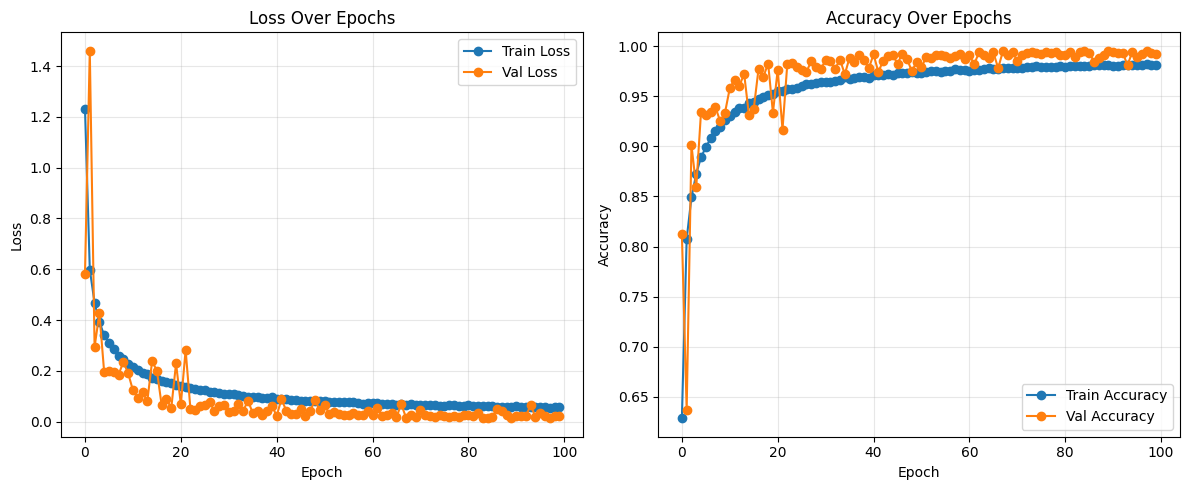

In [11]:

#  Plot Training Graphs

plt.figure(figsize=(12,5))

# 1. Loss Graph

plt.subplot(1,2,1)
plt.plot(history["train_loss"], label="Train Loss", marker="o")
plt.plot(history["val_loss"], label="Val Loss", marker="o")
plt.title("Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True, alpha=0.3)
plt.legend()


# 2. Accuracy Graph

plt.subplot(1,2,2)
plt.plot(history["train_acc"], label="Train Accuracy", marker="o")
plt.plot(history["val_acc"], label="Val Accuracy", marker="o")
plt.title("Accuracy Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(True, alpha=0.3)
plt.legend()

plt.tight_layout()
plt.show()


In [12]:

#  Dynamic Quantization (Optional)


from torch.quantization import quantize_dynamic
import torch.nn as nn

# Ensure model is on CPU (required for quantization)
model_cpu = model.to("cpu").eval()

print("Applying dynamic quantization...")


# 1. Apply dynamic quantization (only Linear layers)

quantized_model = quantize_dynamic(
    model_cpu,
    {nn.Linear},       # quantize only the Fully Connected layers
    dtype=torch.qint8  # 8-bit quantization
)

print(" Quantization completed.")


# 2. Script the quantized model and save

quantized_path = r"C:\Users\AL IMRAN\Desktop\CSE498R\Local\leaf_cnn_quantized.pt"

scripted_quantized = torch.jit.script(quantized_model)
scripted_quantized.save(quantized_path)

print(" Quantized TorchScript model saved to:", quantized_path)



Applying dynamic quantization...
 Quantization completed.
 Quantized TorchScript model saved to: C:\Users\AL IMRAN\Desktop\CSE498R\Local\leaf_cnn_quantized.pt


In [13]:
from torch.quantization import quantize_dynamic
import torch.nn as nn
import os

# Ensure model is on CPU
model_cpu = model.to("cpu").eval()

print("Applying dynamic quantization...")

# 1. Apply dynamic quantization (Linear layers only)
quantized_model = quantize_dynamic(
    model_cpu,
    {nn.Linear},
    dtype=torch.qint8
)

print(" Quantization completed.")

# 2. Script and save quantized model
quantized_path = r"C:\Users\AL IMRAN\Desktop\CSE498R\Local\leaf_cnn_quantized.pt"

scripted_quantized = torch.jit.script(quantized_model)
scripted_quantized.save(quantized_path)

print(" Quantized model saved to:", quantized_path)

# ---------------------------
# 3. Check & print file size
# ---------------------------
file_size_bytes = os.path.getsize(quantized_path)
file_size_kb = file_size_bytes / 1024
file_size_mb = file_size_kb / 1024

print("\n Quantized Model Size:")
print(f"• {file_size_bytes:,} bytes")
print(f"• {file_size_kb:.2f} KB")
print(f"• {file_size_mb:.2f} MB")

Applying dynamic quantization...
 Quantization completed.
 Quantized model saved to: C:\Users\AL IMRAN\Desktop\CSE498R\Local\leaf_cnn_quantized.pt

 Quantized Model Size:
• 3,586,204 bytes
• 3502.15 KB
• 3.42 MB
